# Приоритизация гипотез и анализ A/B теста

**Цель исследования:**
увеличить выручку интернет-магазина.

**Задачи исследвания: **
* приоритизировать гипотезы по увеличению выручки интернет-магазина
* проанализировать результаты A/B теста;

**Данные для исследования: **
* данные о гипотезах по увеличению выручки интернет-магазина с параметрами для расчета
* данные о заказах в ходе A/B теста
* данные о количестве пользователей в группах A и B в ходе теста

### Загрузка данных и библиотек

In [1]:
#загрузка библиотек

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as stats



In [2]:
#загрузка данных

try:
    hypothesis = pd.read_csv('C:/Users/admin/Documents/YP_datasets/AB_test/hypothesis.csv') #гипотезы
    orders = pd.read_csv('C:/Users/admin/Documents/YP_datasets/AB_test/orders.csv') #заказы
    visitors = pd.read_csv('C:/Users/admin/Documents/YP_datasets/AB_test/visitors.csv') #визиты

except:
    visits = pd.read_csv('/my_folder_with_files/hypothesis.csv')
    orders = pd.read_csv('/my_folder_with_files/orders.csv')
    costs = pd.read_csv('/my_folder_with_files/visitors.csv')

In [3]:
#расширим колонки
pd.options.display.max_colwidth = 130

#выведем по 5 первых строк датасетов
print(hypothesis.head(5))
print(orders.head(5))
print(visitors.head(5))

                                                                                                     Hypothesis  \
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
4                              Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей   

   Reach  Impact  Confidence  Efforts  
0      3      10           8        6  
1      2       5           4       10  
2      8       3           7        3  
3      8       3           3        8  
4      3       1           1        1  
   transactionId   visitorId        date  revenue group
0     3667963

In [4]:
#выведем информацию о данных
print(hypothesis.info())
print(orders.info())
print(visitors.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 colum

**Выводы**

Данные и библиотеки загружены. 

После первичного знакомства с данными сделаем следующие изменения:
* сделаем все заголовки в таблицах строчными буквами и без пробелов
* изменим формат столбцов с датой

### Подготовка данных

In [5]:
#переимновываем заголовки

hypothesis.rename(columns = {'Hypothesis':'hypothesis', 'Reach':'reach', 'Impact': 'impact', 'Confidence':'confidence','Efforts':'efforts'}, inplace = True)
orders.rename(columns = {'transactionId':'transaction_id', 'visitorId':'visitor_id'}, inplace = True)


In [6]:
#проверяем
print(hypothesis.head(1))
print(orders.head(1))

                                                                                           hypothesis  \
0  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   

   reach  impact  confidence  efforts  
0      3      10           8        6  
   transaction_id  visitor_id        date  revenue group
0      3667963787  3312258926  2019-08-15     1650     B


In [7]:
#меняем формат для дат
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [8]:
#проверяем
print(orders.info())
print(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None


### Приоритизация гипотез

Приоритизируем гипотезы методами ICE и RICE и сравним результаты:

In [9]:
#добавим столбец ICE и расчитаем показатель
hypothesis['ice'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis['ice']= round(hypothesis['ice'], 1)

In [10]:
#добавим столбец RICE и расчитаем показатель
hypothesis['rice'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

In [11]:
#выведем на экран гипотезы и расчетные показатели
print(hypothesis.loc[:,['hypothesis','ice']].sort_values(by=['ice'], ascending=False))
print(hypothesis.loc[:,['hypothesis','rice']].sort_values(by=['rice'], ascending=False))


                                                                                                     hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользоват

**Выводы**

По методологии ICE лидируют гипотезы по убыванию приоритета:
* Запустить акцию, дающую скидку на товар в день рождения   
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  * Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   

По методологии RICE лидируют гипотезы по убыванию приоритета (две последних получили одинаковые оценки):
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей * Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   

Разница в оценке приоритета связана с тем, что методология RICE учитывает дополнительные параментр а именно скольких пользователей затронет изменение. 

Для тестирования предлагаем остановитьс на гипотезах с приоритетом в порядке убывания:
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей * Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
* Запустить акцию, дающую скидку на товар в день рождения   

### Анализ A/B-теста

#### Кумулятивная выручки по группам

In [12]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

In [13]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

#выводим первые строки таблицы
print(cumulativeData.head(5)) 

#проверяем корретность таблицы сопоставлением максимальной и минимальной даты в исходных и финальных данных. 
print(cumulativeData['date'].min()==orders['date'].min())
print(cumulativeData['date'].max()==orders['date'].max())

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845
True
True


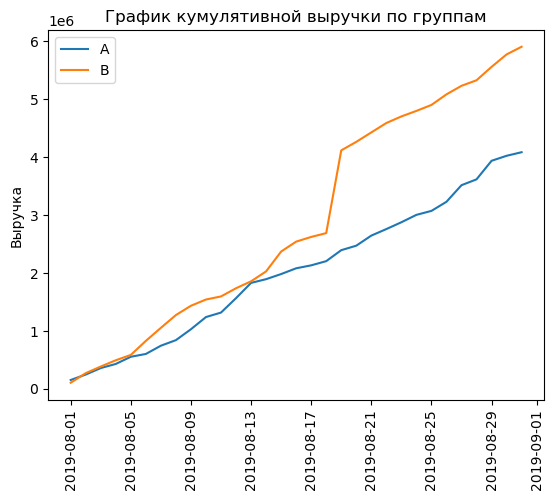

In [14]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.ylabel('Выручка')
plt.xticks(rotation=90); 


**Выводы**

* Кумулятивная выручка обеих групп растет.
* Кумулятивная выручка группы А растет более плавно.
* Кумклятивная выручка группы B делает резкий скачок между 17 и 21 августа. Это может быть связано с увеличением количества заказа или увеличением стоимости нескольких заказов. 

#### Графики среднего чека по группам

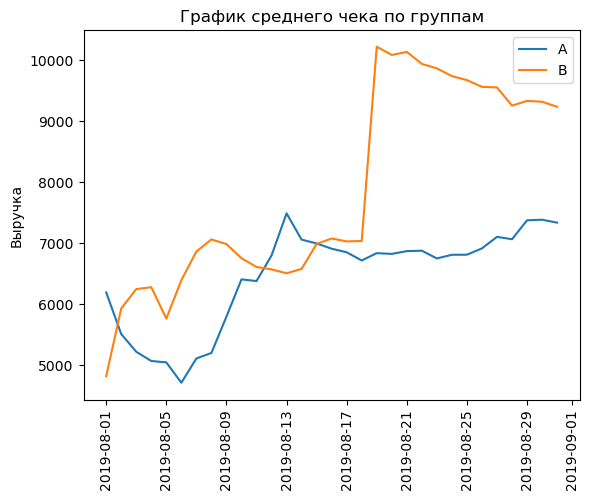

In [15]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('График среднего чека по группам')
plt.ylabel('Выручка')
plt.xticks(rotation=90); 

* Средний чек по группе А нестабилен до до 13 августа, после 13 августа - стабилизируется.
* Средний чек по группе B показывает менее резкие колебания до 17 августа и резкий скачок вверх в районе 18-19 числа, далее немного падает. 
* Можно предположить, что резкий скачок связан все таки с увеличением стоимости нескольких заказов - была сделана дорогая покупка. 

#### Относительное изменение кумулятивного среднего чека

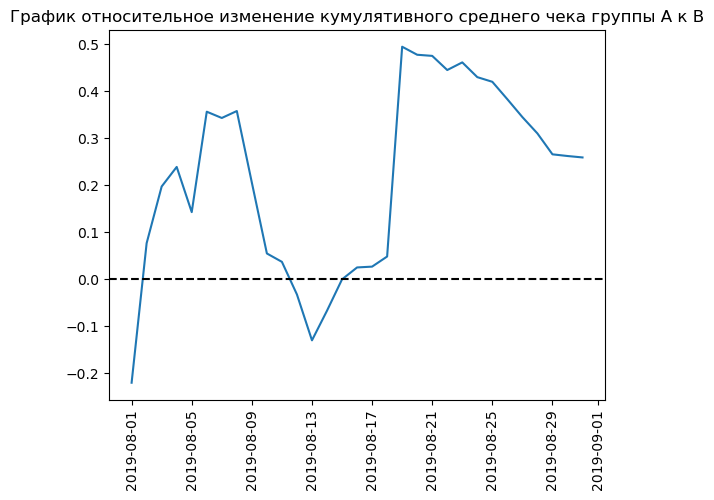

In [16]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('График относительное изменение кумулятивного среднего чека группы A к B')
plt.xticks(rotation=90); 


**Выводы**

В нескольких точках график различия между сегментами резко «скачет». Это означает, что в данных есть выбросы.

#### Кумулятивная конверсия по группам

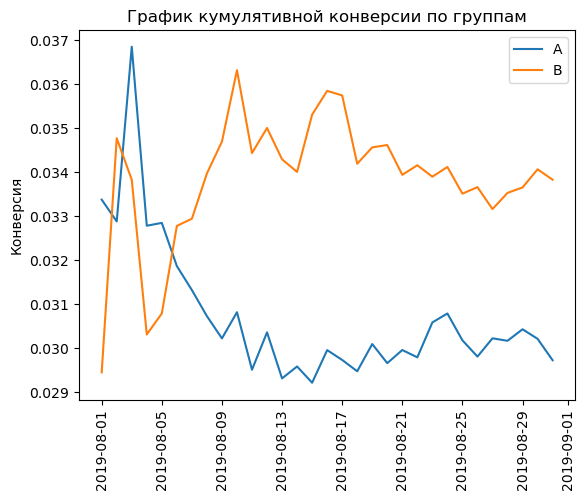

In [17]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивной конверсии по группам')
plt.ylabel('Конверсия')
plt.xticks(rotation=90); 

**Выводы**

* Граффики конверсии колебятся в обеих группах. 
* Сильные колебания видны до 9 августа для обеих групп. После 9 августа графики выравниваются.
* В районе 6 августа конверсия группы B становится выше конверсии группы А и это лидерство сохраняется в дальнейшем.


Построим график относительного различия кумулятивных конверсий:


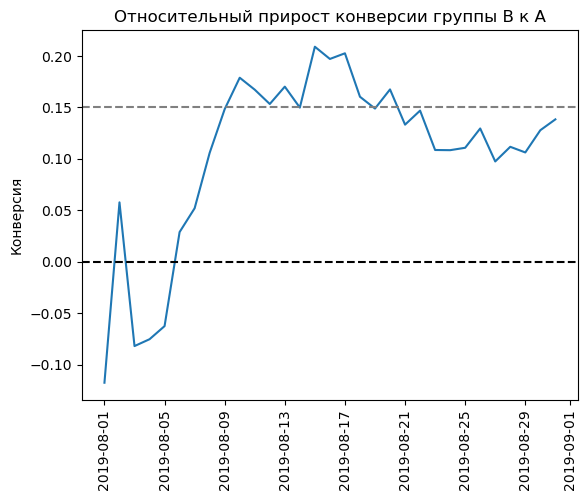

In [18]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('Относительный прирост конверсии группы B к А')
plt.ylabel('Конверсия')
plt.xticks(rotation=90); 

**Выводы**

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Потом её конверсия снова падала, но теперь постепенно растёт.
Для дальнейшего исследования необходимо проанализировать аномалии.

#### Анализ количества заказов

In [19]:
#группипировка заказов по пользователям
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'}))

#изменим названия колонок
ordersByUsers.columns = ['visitor_id', 'orders']

# выведем первые 5 строк
print(ordersByUsers.sort_values(by='orders', ascending=False).head(5))

      visitor_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5


In [20]:
#описательные статистики для поля orders 
ordersByUsers['orders'].describe()

count    1031.000000
mean        1.161009
std         0.724919
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: orders, dtype: float64

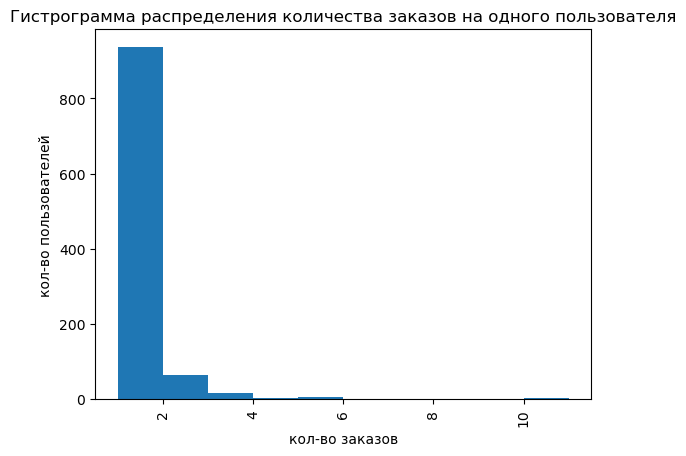

In [21]:
#строим гистограмму
plt.hist(ordersByUsers['orders'])
plt.title('Гистрограмма распределения количества заказов на одного пользователя')
plt.ylabel('кол-во пользователей')
plt.xlabel('кол-во заказов')
plt.xticks(rotation=90); 

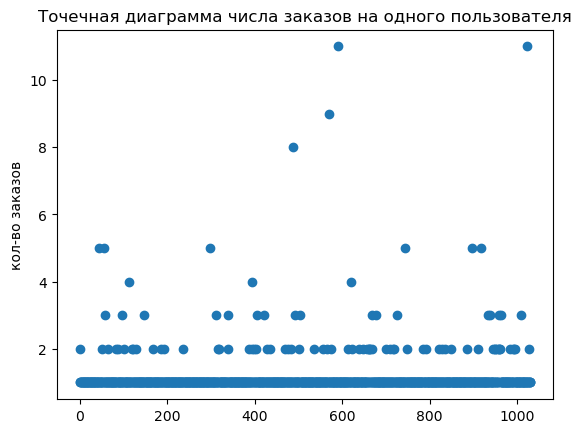

In [22]:
# строим точечную диаграмму числа заказов на одного пользователя
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.ylabel('кол-во заказов');

**Выводы**

* Большинство покупателей заказывали только один раз - 75% равен 1
* Максимальное количество заказов на пользователя в датасете 11.
* Графики показывают, что доля пользователей с 2-3 заказами тоже значительна. 

#### Граница для определения аномальных пользователей

Посчитаем выборочные перцентили количества заказов на одного пользователя

In [23]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 2. 4.]


* Не более 10% пользователей оформляли больше чем 1 заказ.
* Не более 5% пользователей оформляли больше чем 2 заказа. 
* Не более 1% пользователей оформляли больше чем 4 заказа. 

Примем за верхнюю границу 4 заказана пользователя. 

#### Анализ стоимости заказов

In [24]:
#описательные статистики для поля orders 
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

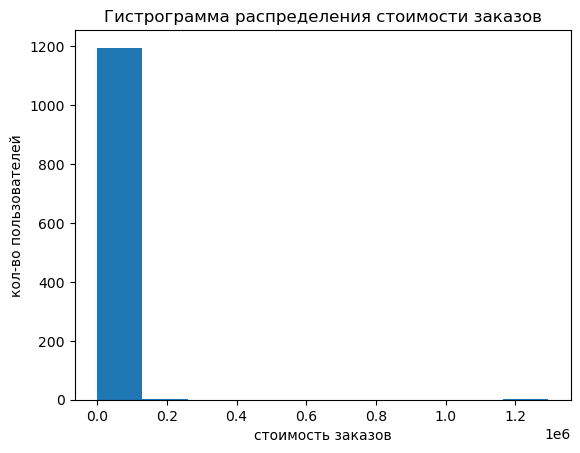

In [25]:
#строим гистограмму
plt.hist(orders['revenue']) 
plt.title('Гистрограмма распределения стоимости заказов')
plt.ylabel('кол-во пользователей')
plt.xlabel('стоимость заказов');


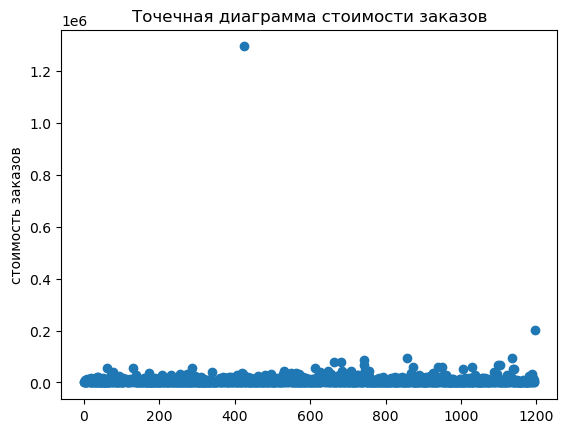

In [26]:
# строим точечную диаграмму 
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечная диаграмма стоимости заказов')
plt.ylabel('стоимость заказов');

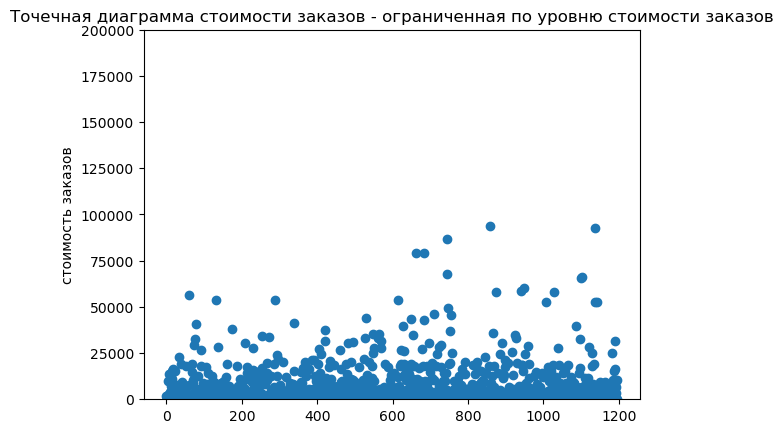

In [27]:
# строим точечную диаграмму 
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечная диаграмма стоимости заказов - ограниченная по уровню стоимости заказов')
plt.ylabel('стоимость заказов')
plt.ylim(0, 200000);

**Выводы**

* Есть большой разрыв между минимальным и максимальной суммой заказа.
* При этом большая часть заказов не превышает порог 25 тысяч.

#### Граница для определения аномальных заказов

Посчитаем выборочные перцентили стоимости заказов

In [28]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


* Не более 10% заказов стоимостью 18 168.
* Не более 5% заказов стоимостью 28 000.
* Не более 1% заказов стоимостью 58 233. 

Примем за верхнюю границу стоимость заказа 58 233.

#### Различия в среднем количестве заказов на посетителя между группами («сырые» данные)

Сформулируем гипотезы. 
H0: различий в среднем количестве заказов между группами нет. 
H1: различия в среднем между группами есть.

Подготовим данные для анализа по пользователям и заказам

In [29]:

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),axis=1,)


visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),axis=1,)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),axis=1,).sort_values(by=['date'])

ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))

ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}),
    axis=1,).sort_values(by=['date'])

ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left'))

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

Посчитаем заказы по пользователям в группах A и B

In [30]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. 

In [31]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

Применим критерий mannwhitneyu(). Установим уровень значимости a=0.05

In [32]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]), 'p-value')

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1), 'относительный прирост B к A')

0.017 p-value
0.138 относительный прирост B к A


**Вывод**

По сырым данным p-value = 0.017. Это меньше a=0.05. Отвергаем нулевую гипотезу, что различий в среднем количестве заказов между группами нет.
Относительный прирост B к A 0.138 (13,8%)

#### Различия в среднем чеке между группами («сырые» данные)

Сформулируем гипотезы.

H0: различий в среднем чеке между группами нет. 

H1: различия в среднем чеке между группами есть.

Уровень значимости 0.05

Передадим критерию mannwhitneyu() данные о выручке с заказов. 
Найдём относительные различия в среднем чеке между группами.

In [33]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]), 'p-value')
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1), 'относительный прирост B к A') 

0.729 p-value
0.259 относительный прирост B к A


**Вывод**

По сырым данным p-value = 0.729. Это больше a=0.05. Не получилось отвергнуть нулевую гипотезу, что различий в среднем чеке нет.
При этом относительный прирост B к A по среднему чеку 0.259 (25,9%).

#### Различия в среднем количестве заказов на посетителя между группами («очищенные» данные)

Сформулируем гипотезы. 
H0: различий в среднем количестве заказов между группами нет. 
H1: различия в среднем между группами есть.

Сделаем срезы пользователей с аномальным числом заказов и аномально дорогими заказами. 
Ранее мы приняли, что:
* примем за верхнюю границу стоимость заказа 58 233 - 99 персентиль.
* примем за верхнюю границу больше 4 заказов - 99 персентиль..

In [34]:

revenue_99=np.percentile(orders['revenue'],[99])
orders_99=np.percentile(ordersByUsers['orders'],[99])

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_99[0]]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_99[0]]['visitor_id'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] >revenue_99[0]]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(revenue_99)
print(orders_99)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

[58233.2]
[4.]
1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64
15


Всего таких "аномальных" пользователей - 15 человек

Подготовим выборки количества заказов по пользователям по группам теста на очищенных данных

In [35]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим критерий mannwhitneyu(). Установим уровень значимости a=0.05

In [36]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]), 'p-value')
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1), 'относительный прирост B к A') 

0.014 p-value
0.153 относительный прирост B к A


Результат  на очищенных данных практически не изменился по сравнению с результатом на сырых данных.
p-value = 0.014. Это меньше a=0.05. Отвергаем нулевую гипотезу, что различий в среднем количестве заказов между группами нет.
Относительный прирост B к A 0.153 (15,3%)

#### Различия в среднем чеке между группами («очищенные» данные)

Сформулируем гипотезы.

H0: различий в среднем чеке между группами нет. 

H1: различия в среднем чеке между группами есть.

Уровень значимости 0.05

In [37]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    ),
'p-value')

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    ),
'относительный прирост B к A') 

0.851 p-value
-0.006 относительный прирост B к A


**Выводы**

Результат  на очищенных данных практически не изменился по сравнению с результатом на сырых данных.
p-value = 0.851. Это больше a=0.05. Не получилось отвергнуть нулевую гипотезу, что различий в среднем чеке нет. 
При этом относительного прироста B к A по среднему чеку фактически нет -0.6%.

### Итоги исследования

В ходе исследования были проанализированы данные интернет магазина, в частности:
* приоритизированы гипотезы по увеличению выручки интернет-магазина
* проанализированы результаты A/B теста;

**Приоритизация гипотез**

Для приоритизации гипотез были использованы 2 метода: ICE и RICE. Второй метод учитывает при расчете приоритизации помимо прочего также охват пользователей. 

Для тестирования предлагаем остановитьс на гипотезах с приоритетом в порядке убывания:

* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
* Запустить акцию, дающую скидку на товар в день рождения

**Результаты A/B тестирования:**

В ходе проверки результатов A/B тестирования мы смотрели на:
* различия в среднем количестве заказов на посетителя между группами 
* различия в среднем чеке между группами 

Различия смотрели как на сырых данных, так и на очищенных от аномальных значений.
За аномальные значения в нашем исследовании были приняты более 4 заказов на пользователя (менее 1% ) и заказы стоимостью выше 58233 (менее 1%). Всего было исключено из очищенных данных 15 пользователей.

Провера гипотез показала что есть статистически значимое различие между группами как на сырых, так и на очищенных данных в среднем количестве заказов.
Нет статистически значимых различий между группами как на сырых, так и на очищенных данных в среднем чеке.

Также график кумулятивной конверсии показывает, что конверсия группы B стабильно выше конверсии группы А.

**Решение по результатам теста**

На основе проведенным проверов рекомундуем остановить тестирование зафиксировав, что конверсия группы B выше по итогам эксперимента.